# Non-Negative Matrix Factorization (NMF)

This notebook consists of two sections: 

1. Text pre-processing
2. Implementing NMF and coherence scores

This notebook is highly inspired by and sometimes directly copied from the NMF tutorial by [Derek Greene](https://github.com/derekgreene) available at his [GitHub Repository](https://github.com/derekgreene/topic-model-tutorial).

# 1. Text preprocessing

In this first section go through the steps involved in preprocessing our Twitter dataset using *scikit-learn*, which we will use in section for topic modelling.

In [1]:
from pathlib import Path
import operator, joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Loading the Documents

We will load these the Twitter data into a list, and also create a short snippet of text for each document.

In [2]:
# Read data
in_path = Path("data") / "tweets_data_temp.txt"
raw_documents = []
snippets = []
with open(in_path, "r") as fin:
    for line in fin.readlines():
        text = line.strip()
        raw_documents.append( text )
        # keep a short snippet of up to 100 characters as a title for each article
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 5748 raw text documents


### Creating a Document-Term Matrix

When preprocessing text, a common approach is to remove non-informative stopwords. The choice of stopwords can have a considerable impact later on. We will use a Danish stopword list by [Bertel Torp](https://gist.github.com/berteltorp) available at his [GitHub Repository](https://gist.github.com/berteltorp/0cf8a0c7afea7f25ed754f24cfc2467b).

In [3]:
in_path = Path("data") / "stopord.txt"
custom_stop_words = []
with open( in_path, "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 262 entries


In the *bag-of-words model*, each document is represented by a vector in a *m*-dimensional coordinate space, where *m* is number of unique terms across all documents. This set of terms is called the corpus *vocabulary*. 

Since each document can be represented as a term vector, we can stack these vectors to create a full *document-term matrix*. We can easily create this matrix from a list of document strings using *CountVectorizer* from Scikit-learn. The parameters passed to *CountVectorizer* control the pre-processing steps that it performs.

In [4]:
# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bl', 'ca', 'eks', 'pga'] not in stop_words.
  warnings.warn(


Created 5748 X 281 document-term matrix


This process also builds a vocabulary for the corpus:

In [5]:
terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 281 distinct terms


We can save this document-term matrix, terms, and snippets for later use using *Joblib* to persist the data.

In [6]:
joblib.dump((A,terms,snippets), "articles-raw.pkl")

['articles-raw.pkl']

### Applying Term Weighting with TF-IDF

We can improve the usefulness of the document-term matrix by giving more weight to the more "important" terms. The most common normalisation is *term frequency–inverse document frequency* (TF-IDF). In Scikit-learn, we can generate at TF-IDF weighted document-term matrix by using *TfidfVectorizer* in place of *CountVectorizer*.

In [7]:
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

Created 5748 X 281 TF-IDF-normalized document-term matrix


In [8]:
terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 281 distinct terms


A simple characterisation that we might do would be to look at the terms with the highest TF-IDF scores across all documents in the document-term matrix. We can define such a function as follows:

In [9]:
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [10]:
#rank_terms(A,terms)

Again we will save this document-term matrix, terms, and snippets for topic modelling later using *Joblib*.

In [11]:
joblib.dump((A,terms,snippets), "articles-tfidf.pkl") 

['articles-tfidf.pkl']

# 2. NMF and coherence scores

This section will outline how to use coherence scores help selecting a useful value for the number of topics *k*.

Note that this notebook requires v4 of the [Gensim package](https://radimrehurek.com/gensim) to be installed.

In [12]:
from pathlib import Path
import re, joblib
from itertools import combinations
import numpy as np
from sklearn import decomposition
import gensim
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# settings for our plots later
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib* (this file is also available in the ```data``` folder in the [GitHub repo](https://github.com/jorgenhw/bachelor_thesis/tree/master/topic_modelling/data)):

In [13]:
(A,terms,snippets) = joblib.load("articles-tfidf.pkl")
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 5748 X 281 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [14]:
kmin, kmax = 4, 100

Apply NMF for each of these values:

In [15]:
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=23 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=24 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=25 ...
Applying NMF for k=26 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=27 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=28 ...
Applying NMF for k=29 ...
Applying NMF for k=30 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=31 ...
Applying NMF for k=32 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=33 ...
Applying NMF for k=34 ...
Applying NMF for k=35 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=36 ...
Applying NMF for k=37 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=38 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=39 ...
Applying NMF for k=40 ...
Applying NMF for k=41 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=42 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=43 ...
Applying NMF for k=44 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=45 ...
Applying NMF for k=46 ...
Applying NMF for k=47 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=48 ...
Applying NMF for k=49 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=50 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=51 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=52 ...
Applying NMF for k=53 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=54 ...
Applying NMF for k=55 ...
Applying NMF for k=56 ...
Applying NMF for k=57 ...
Applying NMF for k=58 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=59 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=60 ...
Applying NMF for k=61 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=62 ...
Applying NMF for k=63 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=64 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=65 ...
Applying NMF for k=66 ...
Applying NMF for k=67 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=68 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=69 ...
Applying NMF for k=70 ...
Applying NMF for k=71 ...
Applying NMF for k=72 ...
Applying NMF for k=73 ...
Applying NMF for k=74 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=75 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=76 ...
Applying NMF for k=77 ...
Applying NMF for k=78 ...
Applying NMF for k=79 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=80 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=81 ...
Applying NMF for k=82 ...
Applying NMF for k=83 ...
Applying NMF for k=84 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=85 ...
Applying NMF for k=86 ...
Applying NMF for k=87 ...
Applying NMF for k=88 ...


/Users/wibe/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=89 ...
Applying NMF for k=90 ...
Applying NMF for k=91 ...
Applying NMF for k=92 ...
Applying NMF for k=93 ...
Applying NMF for k=94 ...
Applying NMF for k=95 ...
Applying NMF for k=96 ...
Applying NMF for k=97 ...
Applying NMF for k=98 ...
Applying NMF for k=99 ...
Applying NMF for k=100 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

We read the documents from the input file again:

In [16]:
in_path = Path("data") / "tweets_data_temp.txt"
raw_documents = []
with open(in_path, "r") as fin:
    # each line is a document
    for line in fin.readlines():
        raw_documents.append( line.strip().lower() )
print("Read %d raw text documents" % len(raw_documents))

Read 5748 raw text documents


Read the custom stopword list:

In [17]:
in_path = Path("data") / "stopord.txt"
custom_stop_words = []
with open( in_path, "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 262 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [18]:
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [19]:
docgen = TokenGenerator( raw_documents, custom_stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, vector_size=500, min_count=20, sg=1) #sg = SkipGram

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [20]:
print("Model has %d terms" % len(w2v_model.wv.key_to_index))

Model has 299 terms


Optional: Save for later use, so that we do not need to rebuild it:

In [21]:
# w2v_model.save("w2v-model.bin")

In [22]:
# To re-load this model, run
#w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [23]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [24]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

Now process each of the models for different values of *k*:

In [25]:
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.9382
K=05: Coherence=0.9548
K=06: Coherence=0.9612
K=07: Coherence=0.9650
K=08: Coherence=0.9679
K=09: Coherence=0.9700
K=10: Coherence=0.9707
K=11: Coherence=0.9694
K=12: Coherence=0.9716
K=13: Coherence=0.9726
K=14: Coherence=0.9724
K=15: Coherence=0.9732
K=16: Coherence=0.9741
K=17: Coherence=0.9744
K=18: Coherence=0.9735
K=19: Coherence=0.9764
K=20: Coherence=0.9734
K=21: Coherence=0.9741
K=22: Coherence=0.9739
K=23: Coherence=0.9744
K=24: Coherence=0.9725
K=25: Coherence=0.9739
K=26: Coherence=0.9743
K=27: Coherence=0.9766
K=28: Coherence=0.9764
K=29: Coherence=0.9780
K=30: Coherence=0.9775
K=31: Coherence=0.9783
K=32: Coherence=0.9790
K=33: Coherence=0.9798
K=34: Coherence=0.9797
K=35: Coherence=0.9801
K=36: Coherence=0.9811
K=37: Coherence=0.9813
K=38: Coherence=0.9814
K=39: Coherence=0.9820
K=40: Coherence=0.9817
K=41: Coherence=0.9827
K=42: Coherence=0.9818
K=43: Coherence=0.9829
K=44: Coherence=0.9831
K=45: Coherence=0.9827
K=46: Coherence=0.9831
K=47: Coher

We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

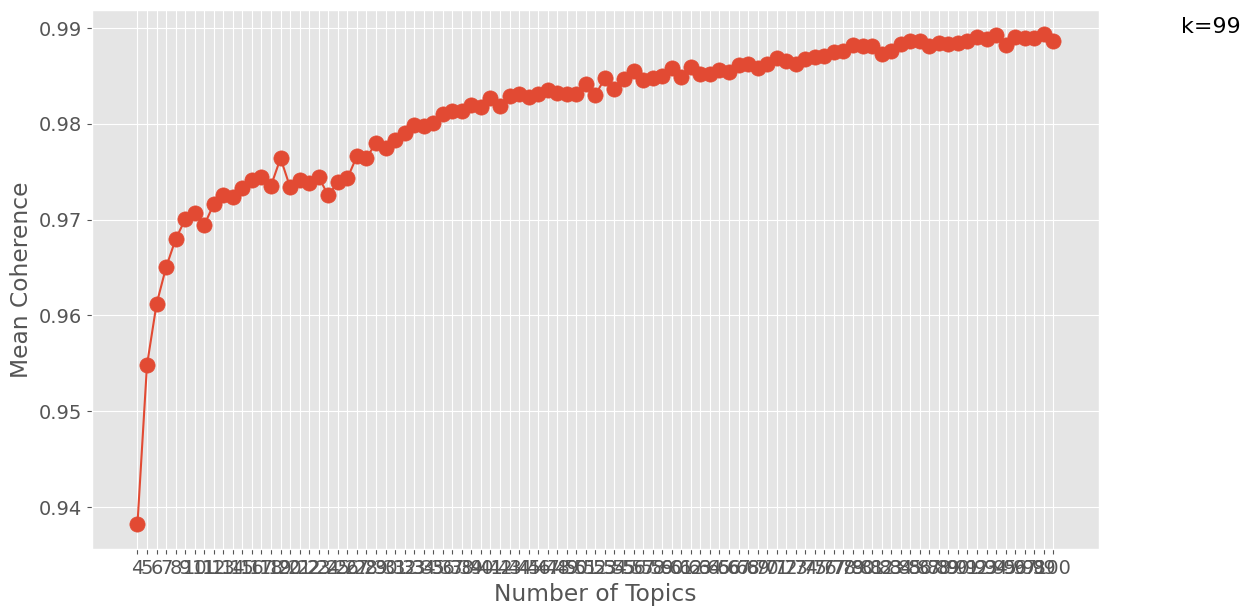

In [26]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate("k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

In [27]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

Display the topic descriptors for this model:

In [28]:
for topic_index in range(k):
    descriptor = get_descriptor(terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % (topic_index+1, str_descriptor) )

Topic 01: link, egne, ligger, hvert, mulighed, fedt, land, betaler, arbejder, søndag
Topic 02: dkpol, eudk, dkøko, snart, valget, støtte, partier, forslag, regering, gratis
Topic 03: user, danmarks, eudk, stemme, kalder, snart, mette, kære, stemmer, største
Topic 04: dkmedier, viser, demokrati, laver, nå, fokus, morgen, holder, politikere, europa
Topic 05: blevet, dage, egentlig, 15, sat, fald, haft, kære, 20, engang
Topic 06: sldk, kamp, brøndby, kampen, fans, fck, gik, gået, aftale, fokus
Topic 07: dag, 30, kort, politisk, snart, viser, gået, blot, slags, sikkert
Topic 08: tror, viser, danskere, bestemt, sociale, desværre, svar, sagt, vælgerne, aftale
Topic 09: nye, fald, europa, viser, valget, kort, side, læse, danskere, krav
Topic 10: år, 20, seneste, 30, 15, hvert, snart, gamle, hjem, haft
Topic 11: danmark, verden, håber, offentlige, nyheder, stå, seneste, parti, 000, ønsker
Topic 12: df, væk, politiske, vælgerne, slet, forkert, regering, gik, regeringen, stemmer
Topic 13: første

Although 30 is the recommended number, it is simply too many topics to be able to make sense of. Considering the relatively small improvement from 10 to 30 topics (0.1) and the advantage of having only 10 topics, we take a look at the data for 10 topics:

In [29]:
for topic_index in range(10):
    descriptor = get_descriptor(terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % (topic_index+1, str_descriptor) )

Topic 01: link, egne, ligger, hvert, mulighed, fedt, land, betaler, arbejder, søndag
Topic 02: dkpol, eudk, dkøko, snart, valget, støtte, partier, forslag, regering, gratis
Topic 03: user, danmarks, eudk, stemme, kalder, snart, mette, kære, stemmer, største
Topic 04: dkmedier, viser, demokrati, laver, nå, fokus, morgen, holder, politikere, europa
Topic 05: blevet, dage, egentlig, 15, sat, fald, haft, kære, 20, engang
Topic 06: sldk, kamp, brøndby, kampen, fans, fck, gik, gået, aftale, fokus
Topic 07: dag, 30, kort, politisk, snart, viser, gået, blot, slags, sikkert
Topic 08: tror, viser, danskere, bestemt, sociale, desværre, svar, sagt, vælgerne, aftale
Topic 09: nye, fald, europa, viser, valget, kort, side, læse, danskere, krav
Topic 10: år, 20, seneste, 30, 15, hvert, snart, gamle, hjem, haft
